# Predicting Credit Card Defaults

## Imports

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    average_precision_score, 
    auc
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR

import matplotlib.pyplot as plt

## The Problem
 
Predicting whether or not a credit card client will default on their payments, using [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). This is a (30000, 24) shaped data set of credit card users from Taiwan, with the goal being a proper binary classification of will default (0), or will not default (1).

## Initial Thoughts

The problem is one that I will create a classifier for, one thing that I did notice is that a lot of the columns are very similar, so I am wondering if there is some kind of feature engineering I can do to compare against using all of them. The target column has about a 3:1 ratio of will default (0) to not defaulting (1), so I don't think I will have to do anything to balance the data set. I noticed that there were no missing values but the feature names were a bit confusing so I may change those to make more sense to me.

## Data splitting <a name="2"></a>
<hr>

In [14]:
data_read = pd.read_csv("data/UCI_Credit_Card.csv")
data = pd.DataFrame(data_read)
data['default.payment.next.month'].value_counts() # data set does not need to be balanced

0    23364
1     6636
Name: default.payment.next.month, dtype: int64

In [15]:
train_df, test_df = train_test_split(data, test_size = .8, random_state=981)
X_train, y_train = train_df.drop(columns=['default.payment.next.month']), train_df['default.payment.next.month']
X_test, y_test = test_df.drop(columns=['default.payment.next.month']), test_df['default.payment.next.month']

In [16]:
len(train_df), len(test_df)

(6000, 24000)

## 3. EDA <a name="3"></a>
<hr>

In [64]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 26699 to 4730
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          6000 non-null   int64  
 1   LIMIT_BAL                   6000 non-null   float64
 2   SEX                         6000 non-null   int64  
 3   EDUCATION                   6000 non-null   int64  
 4   MARRIAGE                    6000 non-null   int64  
 5   AGE                         6000 non-null   int64  
 6   PAY_0                       6000 non-null   int64  
 7   PAY_2                       6000 non-null   int64  
 8   PAY_3                       6000 non-null   int64  
 9   PAY_4                       6000 non-null   int64  
 10  PAY_5                       6000 non-null   int64  
 11  PAY_6                       6000 non-null   int64  
 12  BILL_AMT1                   6000 non-null   float64
 13  BILL_AMT2                   6

In [65]:
train_df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,...,6000.000000,6000.000000,6000.000000,6000.000000,6.000000e+03,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,15176.264500,168496.280000,1.599000,1.850833,1.553000,35.492667,-0.021500,-0.135500,-0.155000,-0.220000,...,43801.479167,40675.672167,38952.066500,5916.840833,6.152459e+03,5660.367500,5197.929667,4703.160833,4995.958833,0.212833
std,8736.453057,129243.439425,0.490142,0.793949,0.518879,9.236079,1.116802,1.203349,1.198004,1.168401,...,66312.449941,61552.677943,60384.446292,18360.397603,2.405962e+04,21844.430165,17391.926062,14991.946417,16038.779010,0.409345
min,4.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-81334.000000,-53007.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7658.250000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2338.500000,1799.250000,1170.000000,1000.000000,7.965000e+02,399.250000,255.000000,163.250000,11.750000,0.000000
50%,15182.000000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,18592.500000,17917.000000,16395.500000,2080.500000,2.000000e+03,1809.500000,1500.000000,1492.500000,1455.000000,0.000000
75%,22822.500000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54771.500000,50277.750000,48829.000000,5186.500000,5.000000e+03,4500.000000,4201.000000,4002.000000,4005.000000,0.000000
max,29998.000000,780000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,7.000000,7.000000,8.000000,...,706864.000000,530672.000000,496915.000000,873552.000000,1.215471e+06,889043.000000,621000.000000,332000.000000,345293.000000,1.000000


The code above quickly looks at some descriptive values for every "demographic" column in the training dataset. This shows us if any columns are unbalanced, which seems to not be the case. The sexes of participants is almost evenly split, the average education level is higher than university level, and there is a relatively even split of married and unmarried people. The age column is skewed towards younger people based on the maximum age, and I am interested to see how this affects the classifications.

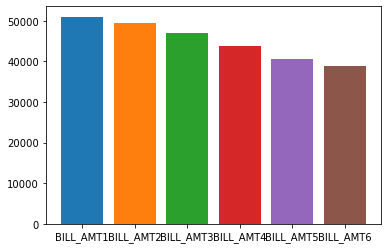

In [6]:
for col in train_df.columns[12:18]:
    plt.bar(col, np.mean(train_df[col]))

The above plot shows the average value for each of the bill amount columns. These columns could be combined at a later time to test out some feature engineering since the mean values are quite similar.

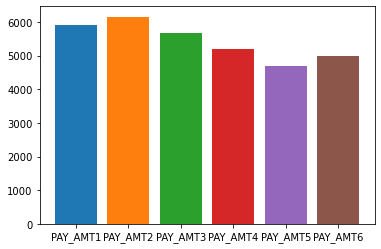

In [7]:
for col in train_df.columns[18:24]:
    plt.bar(col, np.mean(train_df[col]))

This plot shows the average value for each of the pay amount columns. I will also be combining these with each other/against the bill pay amounts as tests for feature engineering as both sets of columns are separated by month.

Since I am using classification, I will use some usual classification scoring metrics, such as: accuracy, precision, recall and f1 score. Choosing these metrics will allow me to select different models to use by maximizing certain scores. For example, if I decide that I want to maximize the true positive prediction probability then I would want to use which ever model has the highest recall score. This project will focus more on testing out different engineered features on various classifiers, with not as much focus on maximizing metrics apart from pure accuracy. If I were to do this project again, I would most likely focus on the accuracy and recall as I would think that credit card companies would not want to accidentally increase the credit on a client who is likely to default on a payment.

In [24]:
scoring_metrics = ['accuracy', 'f1', 'recall', 'precision']

## Feature engineering <a name="4"></a>
<hr>

I am not an expert in credit card defaults nor do I know anyone who is, so the feature engineering I perform here will only be used as a comparison to models which use non-engineered features. I do not expect better model scores by using these engineered features, and am doing so just because I am curious to see if they make a difference.

In [17]:
# New feature #1: combining each set of pay amount and bill amount to be a total pay or bill amount over the 6 months that the data is from.
X_train_fe1 = X_train.copy(deep=True) # make copy of training dataframe
X_train_fe1['total_pay_amt'] = X_train_fe1[X_train_fe1.columns[18:24].values].sum(axis=1) #create new column of total payment amount for every row
X_train_fe1.drop(columns=X_train_fe1.columns[18:24].values, inplace=True)

# New feature #2: combining bill amount
X_train_fe2 = X_train.copy(deep=True) # make copy of training dataframe
X_train_fe2['total_bill_amt'] = X_train_fe2[X_train_fe2.columns[12:18].values].sum(axis=1) #create new column of total bill amount for every row
X_train_fe2.drop(columns=X_train_fe2.columns[12:18].values, inplace=True)

# New feature #3: combining new feature #1 and #2 to create a difference in monthly bill and pay amount column
X_train_fe3 = X_train.copy(deep=True)
for i in range(12,18):
    X_train_fe3['BP_diff_AMT' + str(i-11)] = X_train_fe3[X_train_fe3.columns[i]] - X_train_fe3[X_train_fe3.columns[i+6]]
X_train_fe3.drop(columns=X_train_fe3.columns[12:24].values, inplace=True)

# New feature #4: same thing as feature #3 except now summing the differences down to a single column
X_train_fe4 = X_train_fe3.copy(deep=True)
X_train_fe4['tot_BP_diff'] = X_train_fe4[X_train_fe4.columns[13:19].values].sum(axis=1)
X_train_fe4.drop(columns=X_train_fe4.columns[13:19].values, inplace=True)

To make keeping track of each new feature dataframe easier, here is a comprehensive list (noting that the first 3 features all start from the base training dataframe):
 - Feature 1: Sum all the payment amounts to a single "total" column and drop the individual payment columns
 - Feature 2: Sum all the bill amounts to a single "total" column and drop the individual bill columns
 - Feature 3: Take the difference between each bill amount column and its corresponding payment amount column, result is 6 new "difference" columns
 - Feature 4: Starts from the feature #3 dataframe, simply sums all the difference columns to a single resulting "total" difference between all bill amounts and payment amounts.
 
Once again I would like to reiterate that I am not an expert in any field similar to credit card payments/defaults and these new features I created are going to be compared against the base dataset purely out of curiosity.

## Preprocessing and transformations <a name="5"></a>
<hr>


PPC for the base data:

In [18]:
def ppc_fit(num_cols, df2fit):
    """Transforms columns
    
    Pameters
    --------
    num_cols : list or np.array
      List or array of numeric columns for the column transformer
      
    df2fit : pd.DataFrame
      pandas Dataframe of data to fit the column transformer
      
    Returns
    -------
    fit_ppcdf : fit and transformed input data
    """
    drop_cols = ['ID']
    pass_cols = ['SEX', 'EDUCATION', 'MARRIAGE']
    ppc = make_column_transformer((StandardScaler(), num_cols),
                                    ("passthrough", pass_cols),
                                     ("drop", drop_cols))# don't need an additional param for drop cols since they will all be the same
    fit_ppcdf = ppc.fit_transform(df2fit)
    
    return fit_ppcdf

In [19]:
num_cols = ['LIMIT_BAL','AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [20]:
default_ppc = ppc_fit(num_cols,X_train)
fe1_ppc = ppc_fit(np.append(X_train_fe1.columns[1],X_train_fe1.columns[5:].values), X_train_fe1) #these have to be repeated as the number of cols after index 5 in the dataframes changes
fe2_ppc = ppc_fit(np.append(X_train_fe2.columns[1],X_train_fe2.columns[5:].values), X_train_fe2)
fe3_ppc = ppc_fit(np.append(X_train_fe3.columns[1],X_train_fe3.columns[5:].values), X_train_fe3)
fe4_ppc = ppc_fit(np.append(X_train_fe4.columns[1],X_train_fe4.columns[5:].values), X_train_fe4)

What I just did here was set up a data pre-processor which will transform the raw data into something that is more usable for the classifiers. I specified the column that I will not be using (`ID`), specified columns that will not be changed at all as they are already numerically represented correctly (`SEX`, `EDUCATION`, `MARRIAGE`), and then passed the rest of the columns through a standard scaler. The scaling will allow the models to work with columns that have had their means removed and been scaled to the unit variance, essentially making each column somewhat follow a normal distribution. This in turn makes each feature more comparable by standardizing the scale for each one.

## Baseline model <a name="6"></a>
<hr>

Firstly, I will define a scoring function.

In [21]:
results_default = {} # creating the dictionary for results on the default X_train with no feature engineering

In [22]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    -------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [25]:
results_default['DC'] = mean_std_cross_val_scores(DummyClassifier(), X_train, y_train, return_train_score=True,scoring=scoring_metrics)
pd.DataFrame(results_default)

/Users/samquist/miniconda3/envs/573/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samquist/miniconda3/envs/573/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samquist/miniconda3/envs/573/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samquist/miniconda3/envs/573/lib/python3.9/site-

,DC
fit_time,0.002 (+/- 0.001)
score_time,0.006 (+/- 0.004)
test_accuracy,0.787 (+/- 0.000)
train_accuracy,0.787 (+/- 0.000)
test_f1,0.000 (+/- 0.000)
train_f1,0.000 (+/- 0.000)
test_recall,0.000 (+/- 0.000)
train_recall,0.000 (+/- 0.000)
test_precision,0.000 (+/- 0.000)
train_precision,0.000 (+/- 0.000)


I am getting all those errors from the fact that the dummy classifier always classified as "will default" (0), so some of our scoring metrics which incorporate the amount of false positives or negatives in the denominator will result in warnings due to division by zero.

## Linear model
<hr>


I will use SVC as our linear model to test here. Hyperparameter tuning will only be done on the base training set (with no engineered features) as optimizing the parameters for every training set would take too much time. The method I plan to follow will find the best hyperparameter for the base set and compare it to the non-optimized scores of the engineered data sets.

In [26]:
results_default['SVC'] = mean_std_cross_val_scores(SVC(random_state=981), default_ppc, y_train, return_train_score=True,scoring=scoring_metrics)
pd.DataFrame(results_default)

,DC,SVC
fit_time,0.002 (+/- 0.001),0.709 (+/- 0.057)
score_time,0.006 (+/- 0.004),0.291 (+/- 0.017)
test_accuracy,0.787 (+/- 0.000),0.827 (+/- 0.007)
train_accuracy,0.787 (+/- 0.000),0.836 (+/- 0.003)
test_f1,0.000 (+/- 0.000),0.439 (+/- 0.018)
train_f1,0.000 (+/- 0.000),0.475 (+/- 0.010)
test_recall,0.000 (+/- 0.000),0.319 (+/- 0.017)
train_recall,0.000 (+/- 0.000),0.349 (+/- 0.010)
test_precision,0.000 (+/- 0.000),0.707 (+/- 0.053)
train_precision,0.000 (+/- 0.000),0.744 (+/- 0.016)


In [27]:
#tune hyperparameters
param_grid = {"C" : np.linspace(.2,4,20)}  # using random search so I can have some fairly large ranges of C to work with
              
random_search = RandomizedSearchCV(
    SVC(random_state=981),
    param_grid,
    n_jobs=-1,
    n_iter=5,
    cv=5,
    random_state=981,
    return_train_score=True)
random_search.fit(default_ppc, y_train);

In [28]:
print(random_search.best_params_)
random_search.best_score_

{'C': 1.5999999999999999}


0.8281666666666666

From the results above, looks like I will be using C = 1.6.

In [29]:
#redo the CV scoring using tuned hyperparameters
results_default['SVC'] = mean_std_cross_val_scores(SVC(C=1.6, random_state=981), default_ppc, y_train, return_train_score=True,scoring=scoring_metrics)
pd.DataFrame(results_default)

,DC,SVC
fit_time,0.002 (+/- 0.001),0.726 (+/- 0.035)
score_time,0.006 (+/- 0.004),0.304 (+/- 0.012)
test_accuracy,0.787 (+/- 0.000),0.828 (+/- 0.008)
train_accuracy,0.787 (+/- 0.000),0.839 (+/- 0.003)
test_f1,0.000 (+/- 0.000),0.447 (+/- 0.030)
train_f1,0.000 (+/- 0.000),0.488 (+/- 0.009)
test_recall,0.000 (+/- 0.000),0.327 (+/- 0.026)
train_recall,0.000 (+/- 0.000),0.361 (+/- 0.008)
test_precision,0.000 (+/- 0.000),0.711 (+/- 0.049)
train_precision,0.000 (+/- 0.000),0.753 (+/- 0.018)


The SVC clearly performs better than the baseline, with the regularization parameter being 1.6 which means the 'strength' of the regularization is 1/C = .625. The scoring accuracy does not change, but every other scoring metric increases when I use this regularization parameter, but not by values larger than .025.

Now to test SVC with the selected hyperparameter value on the engineered training data.

In [30]:
#group the training dataframes together to allow for looping cross validation scores
results_engineered = {}
feats = [fe1_ppc, fe2_ppc, fe3_ppc, fe4_ppc]
i = 0
for feat in feats:
    i = i+1
    name = 'SVC_feat' + str(i)
    results_engineered[name] = mean_std_cross_val_scores(SVC(C=1.6,random_state=981), feat, y_train, return_train_score=True,scoring=scoring_metrics)

In [31]:
pd.DataFrame(results_engineered)

,SVC_feat1,SVC_feat2,SVC_feat3,SVC_feat4
fit_time,0.679 (+/- 0.035),0.641 (+/- 0.008),0.715 (+/- 0.027),0.715 (+/- 0.018)
score_time,0.280 (+/- 0.016),0.266 (+/- 0.006),0.293 (+/- 0.010),0.274 (+/- 0.005)
test_accuracy,0.830 (+/- 0.008),0.830 (+/- 0.008),0.829 (+/- 0.008),0.830 (+/- 0.008)
train_accuracy,0.838 (+/- 0.003),0.839 (+/- 0.003),0.838 (+/- 0.002),0.839 (+/- 0.003)
test_f1,0.456 (+/- 0.027),0.458 (+/- 0.024),0.454 (+/- 0.028),0.461 (+/- 0.026)
train_f1,0.487 (+/- 0.008),0.490 (+/- 0.010),0.489 (+/- 0.008),0.492 (+/- 0.010)
test_recall,0.336 (+/- 0.024),0.337 (+/- 0.020),0.335 (+/- 0.025),0.341 (+/- 0.025)
train_recall,0.362 (+/- 0.008),0.364 (+/- 0.009),0.363 (+/- 0.008),0.366 (+/- 0.009)
test_precision,0.712 (+/- 0.050),0.716 (+/- 0.057),0.707 (+/- 0.049),0.713 (+/- 0.055)
train_precision,0.747 (+/- 0.016),0.752 (+/- 0.014),0.746 (+/- 0.015),0.752 (+/- 0.017)


The results here do not suggest any crazy improvement, and can act more as a baseline for when I try different models in the next few cells.

## Different models
<hr>

Here I will try using some non-linear models: RandomForestClassifier, DecisionTreeClassifier with a max depth of 6000, and KNeighborsClassifier. The comparison between models will be done using `ppc_default`, which is the transformed `X_train` with no feature engineering.

In [32]:
models = [RandomForestClassifier(random_state=981), DecisionTreeClassifier(max_depth=6000, random_state=981), KNeighborsClassifier()]
model_names = ['RFC', 'DTC', 'KNC']
for i in range(3):
    results_default[model_names[i]] = mean_std_cross_val_scores(models[i], default_ppc, y_train, return_train_score=True,scoring=scoring_metrics)

In [33]:
pd.DataFrame(results_default)

,DC,SVC,RFC,DTC,KNC
fit_time,0.002 (+/- 0.001),0.726 (+/- 0.035),0.865 (+/- 0.051),0.070 (+/- 0.004),0.001 (+/- 0.000)
score_time,0.006 (+/- 0.004),0.304 (+/- 0.012),0.025 (+/- 0.000),0.003 (+/- 0.000),0.165 (+/- 0.013)
test_accuracy,0.787 (+/- 0.000),0.828 (+/- 0.008),0.823 (+/- 0.005),0.727 (+/- 0.019),0.806 (+/- 0.014)
train_accuracy,0.787 (+/- 0.000),0.839 (+/- 0.003),1.000 (+/- 0.000),1.000 (+/- 0.000),0.850 (+/- 0.004)
test_f1,0.000 (+/- 0.000),0.447 (+/- 0.030),0.461 (+/- 0.029),0.379 (+/- 0.038),0.444 (+/- 0.050)
train_f1,0.000 (+/- 0.000),0.488 (+/- 0.009),0.999 (+/- 0.000),0.999 (+/- 0.000),0.569 (+/- 0.015)
test_recall,0.000 (+/- 0.000),0.327 (+/- 0.026),0.358 (+/- 0.038),0.392 (+/- 0.039),0.364 (+/- 0.047)
train_recall,0.000 (+/- 0.000),0.361 (+/- 0.008),0.998 (+/- 0.001),0.998 (+/- 0.001),0.465 (+/- 0.016)
test_precision,0.000 (+/- 0.000),0.711 (+/- 0.049),0.654 (+/- 0.033),0.368 (+/- 0.040),0.570 (+/- 0.050)
train_precision,0.000 (+/- 0.000),0.753 (+/- 0.018),1.000 (+/- 0.000),1.000 (+/- 0.000),0.733 (+/- 0.011)


From our results, you can see that none of the classification models could do better than the linear model I used earlier in terms of test accuracy. Furthermore, the random forest and K neighbor classifiers did not overfit a ton, but there is a bit of overfitting. The decision tree classifier did however show a substantial amount of overfitting as the train score was quite high but the test score was the lowest of all 4 algorithmic models, even doing worse than the dummy classifier. The fit times were lower than the linear model for the decision tree and k neighbor classifiers and higher for the random forest classifier, with the KNC being magnitudes faster than the linear model in fit time (.001s vs. ~.8s). The score times were all faster for the classification models compared to the linear model, all by a substantial amount except for the KNC, which was only around 2x faster to score. Overall, using the transformed data that I have I do not see these classification models performing better than the linear model I found earlier in terms of accuracy. 

Now, I will test the models on each of the engineered features to see if they perform better in any way.

In [34]:
models = [RandomForestClassifier(random_state=981), DecisionTreeClassifier(max_depth=6000, random_state=981), KNeighborsClassifier()]
model_names = ['RFC', 'DTC', 'KNC']
z = 0
for feat in feats:
    z = z + 1
    for i in range(3):
        results_engineered[model_names[i] + 'feat' + str(z)] = mean_std_cross_val_scores(models[i], feat, y_train, return_train_score=True,scoring=scoring_metrics)

In [35]:
pd.DataFrame(results_engineered).T.sort_index()

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
DTCfeat1,0.051 (+/- 0.004),0.003 (+/- 0.000),0.728 (+/- 0.015),1.000 (+/- 0.000),0.380 (+/- 0.018),0.999 (+/- 0.000),0.391 (+/- 0.026),0.998 (+/- 0.001),0.370 (+/- 0.025),1.000 (+/- 0.000)
DTCfeat2,0.045 (+/- 0.003),0.003 (+/- 0.000),0.735 (+/- 0.006),1.000 (+/- 0.000),0.394 (+/- 0.006),0.999 (+/- 0.000),0.405 (+/- 0.011),0.998 (+/- 0.001),0.383 (+/- 0.009),1.000 (+/- 0.000)
DTCfeat3,0.048 (+/- 0.002),0.003 (+/- 0.000),0.730 (+/- 0.017),1.000 (+/- 0.000),0.384 (+/- 0.035),0.999 (+/- 0.000),0.395 (+/- 0.039),0.998 (+/- 0.001),0.374 (+/- 0.035),1.000 (+/- 0.000)
DTCfeat4,0.018 (+/- 0.001),0.003 (+/- 0.000),0.732 (+/- 0.011),1.000 (+/- 0.000),0.395 (+/- 0.029),0.999 (+/- 0.000),0.412 (+/- 0.046),0.998 (+/- 0.001),0.380 (+/- 0.022),1.000 (+/- 0.000)
KNCfeat1,0.001 (+/- 0.000),0.162 (+/- 0.003),0.806 (+/- 0.016),0.850 (+/- 0.005),0.447 (+/- 0.050),0.570 (+/- 0.017),0.367 (+/- 0.044),0.467 (+/- 0.018),0.570 (+/- 0.059),0.731 (+/- 0.013)
KNCfeat2,0.001 (+/- 0.000),0.162 (+/- 0.005),0.807 (+/- 0.013),0.852 (+/- 0.004),0.448 (+/- 0.050),0.575 (+/- 0.011),0.370 (+/- 0.052),0.472 (+/- 0.011),0.572 (+/- 0.046),0.736 (+/- 0.013)
KNCfeat3,0.001 (+/- 0.000),0.163 (+/- 0.002),0.806 (+/- 0.015),0.850 (+/- 0.005),0.446 (+/- 0.047),0.569 (+/- 0.017),0.368 (+/- 0.043),0.465 (+/- 0.018),0.566 (+/- 0.054),0.733 (+/- 0.013)
KNCfeat4,0.006 (+/- 0.005),0.075 (+/- 0.005),0.809 (+/- 0.015),0.850 (+/- 0.004),0.456 (+/- 0.044),0.572 (+/- 0.015),0.377 (+/- 0.040),0.469 (+/- 0.016),0.578 (+/- 0.058),0.732 (+/- 0.013)
RFCfeat1,0.854 (+/- 0.041),0.026 (+/- 0.001),0.821 (+/- 0.006),1.000 (+/- 0.000),0.462 (+/- 0.024),0.999 (+/- 0.000),0.363 (+/- 0.032),0.998 (+/- 0.001),0.640 (+/- 0.035),1.000 (+/- 0.000)
RFCfeat2,0.711 (+/- 0.012),0.025 (+/- 0.000),0.824 (+/- 0.008),1.000 (+/- 0.000),0.478 (+/- 0.028),0.999 (+/- 0.000),0.378 (+/- 0.033),0.998 (+/- 0.001),0.652 (+/- 0.039),1.000 (+/- 0.000)


The above dataframe is fairly difficult to read, and an unfortunate side effect from using for loops when running multiple models on multiple training sets. The takeaway from this dataframe is that for every classification model cross validated on every engineered feature training set, there is not a single one that performs better than the linear classifier (SVC) on that same training set (with the metric being test accuracy). The model closest to the support vector classifier performance was the random forest classifier, which is the same result as the non-engineered dataset.

## Hyperparameter optimization 
<hr>


#### RandomForestClassifier:

In [36]:
params = {"n_estimators" : [1,5,10,20,50,100,200]}
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=981),
    params,
    n_jobs=-1,
    n_iter=5,
    cv=5,
    random_state=981,
    return_train_score=True)
random_search.fit(default_ppc, y_train);

In [37]:
print(random_search.best_params_)
random_search.best_score_

{'n_estimators': 200}


0.8233333333333333

You can see from above that the best value of `n_estimators` for our random forest classifier was 200, with the best score being marginally higher than our test score from the previous exercise (where I didn't tune any hyperparameters). Since I am choosing how many estimators the forest will use when classifying, if I were to continue to increase this parameter then I could start to get some scores quite a bit higher than the test scores from before. The drawback to doing this however is that the model will almost be guaranteed to be overfit on the training data and will most likely not score well on the test data.

#### DecisionTreeClassifier:

In [38]:
params = {"max_depth" : [1,5,10,50,100,500,1000]}
random_search = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=981),
    params,
    n_jobs=-1,
    n_iter=5,
    cv=5,
    random_state=981,
    return_train_score=True)
random_search.fit(default_ppc, y_train);

In [39]:
print(random_search.best_params_)
random_search.best_score_

{'max_depth': 1}


0.8296666666666667

This hyperparameter is somewhat difficult to optimize in our situation as there is a high risk of overfitting the data. You can see from the randomized search that the "best" parameter value was 1, which means that there is a single "tree" being used to classify all of the data! A visualization of that single tree is below.

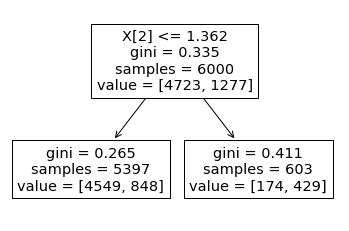

In [30]:
from sklearn import tree
dtc = DecisionTreeClassifier(max_depth=1, random_state=981)
dtc.fit(default_ppc, y_train)
tree.plot_tree(dtc);

The only feature being used is the `EDUCATION` column, which suggests that the model has associated a higher education level with not defaulting on credit card payments. (See Interpretation of feature importances for a discussion as to why this is could be problematic)

#### KNeighborsClassifier:

In [40]:
params = {"n_neighbors" : [5,10,15,20,30],
          "weights" : ['uniform', 'distance']}
random_search = RandomizedSearchCV(
    KNeighborsClassifier(),
    params,
    n_jobs=-1,
    n_iter=5,
    cv=5,
    random_state=981,
    return_train_score=True)
random_search.fit(default_ppc, y_train);

In [41]:
print(random_search.best_params_)
random_search.best_score_

{'weights': 'uniform', 'n_neighbors': 15}


0.8188333333333333

The selected features above improved our test score by .012. The best parameters for the KNeighborsClassifier for our case is `n_neighbors` = 15 and using uniform weights, where distance away from the point does not affect the strength of the point's "vote".

## Interpretation and feature importances 
<hr>


In [42]:
#We'll use the RandomForestClassifier
#A new preprocessor pipeline will be created as you cannot use `get_feature_names_out` with `make_column_transformer`.
drop_cols = ['ID'] #redifining these 2 sets of columns as they are only defining inside a function before this
pass_cols = ['SEX', 'EDUCATION', 'MARRIAGE']
ppc = make_column_transformer((StandardScaler(), num_cols),
                                     ("passthrough", pass_cols),
                                     ("drop", drop_cols)) #same ppc as earlier
pipe_rfc = make_pipeline(ppc, RandomForestClassifier(n_estimators=200,random_state=981))
pipe_rfc.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['LIMIT_BAL', 'AGE', 'PAY_0',
                                                   'PAY_2', 'PAY_3', 'PAY_4',
                                                   'PAY_5', 'PAY_6',
                                                   'BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6',
                                                   'PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                                                   'PAY_AMT5', 'PAY_AMT6']),
                                                 ('passthrough', 'passthrough',
                                                  ['SEX', 'ED

In [43]:
import eli5

eli5.explain_weights(pipe_rfc.named_steps['randomforestclassifier'], feature_names=X_train.columns[1:].values)

Weight,Feature
0.1003 ± 0.0858,EDUCATION
0.0635 ± 0.0172,SEX
0.0569 ± 0.0181,LIMIT_BAL
0.0567 ± 0.0195,PAY_4
0.0534 ± 0.0208,PAY_5
0.0512 ± 0.0173,PAY_6
0.0501 ± 0.0208,BILL_AMT4
0.0492 ± 0.0183,BILL_AMT3
0.0492 ± 0.0178,BILL_AMT1
0.0490 ± 0.0171,BILL_AMT2


You can see that there is clearly a feature that affects the classification the most, `EDUCATION`, that has a weight of .1. The next few features listed are all quite close in terms of importance, being `SEX`, `LIMIT_BAL`, and some pay features.

There is a potential issue with this model, which goes back to choosing which features to include and which to not. Since I decided to include the `SEX` column, I must address the fact that this model can imply sexist findings. This model is only going to be used in a private setting, so I have decided to leave the feature in to talk about the implications of doing so. If the model were to be used for a real-world application I would have to remove any feature that could potentially disenfranchise any specific demographic of people. The model would then have an innate bias from the training data and make unethical classifications, which I do not want to have happen. There is also the potential bias that can arise from using `EDUCATION` as a feature, in the US, there is evidence of correlation between socioeconomic status and education level. However, the data is from Taiwan users so I cannot say if the correlation is still present there as it is in the US.

Feature importances of engineered data sets with individual cross validate scores:

In [44]:
datasets = [X_train_fe1, X_train_fe2, X_train_fe3, X_train_fe4]
pipes = []
i = 0
RFC_eng_results = {}
for dataset in datasets:
    numeric_cols = np.append(dataset.columns[1],dataset.columns[5:].values)
    ppc = make_column_transformer((StandardScaler(), numeric_cols),
                                     ("passthrough", pass_cols),
                                     ("drop", drop_cols))
    pipe_rfc_engineered = make_pipeline(ppc, RandomForestClassifier(n_estimators=200,random_state=981))
    pipes.append(pipe_rfc_engineered.fit(dataset,y_train))
    RFC_eng_results['feat' + str(i)] = mean_std_cross_val_scores(pipe_rfc_engineered, dataset, y_train, return_train_score=True,scoring=scoring_metrics)
    i = i + 1
    

In [45]:
pd.DataFrame(RFC_eng_results).T

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
feat0,1.684 (+/- 0.070),0.052 (+/- 0.003),0.822 (+/- 0.003),1.000 (+/- 0.000),0.463 (+/- 0.019),0.999 (+/- 0.000),0.362 (+/- 0.026),0.998 (+/- 0.001),0.647 (+/- 0.021),1.000 (+/- 0.000)
feat1,1.442 (+/- 0.034),0.051 (+/- 0.001),0.824 (+/- 0.007),1.000 (+/- 0.000),0.474 (+/- 0.024),0.999 (+/- 0.000),0.373 (+/- 0.029),0.998 (+/- 0.001),0.655 (+/- 0.037),1.000 (+/- 0.000)
feat2,1.626 (+/- 0.098),0.050 (+/- 0.000),0.824 (+/- 0.007),1.000 (+/- 0.000),0.472 (+/- 0.021),0.999 (+/- 0.000),0.369 (+/- 0.027),0.998 (+/- 0.001),0.658 (+/- 0.044),1.000 (+/- 0.000)
feat3,0.936 (+/- 0.034),0.056 (+/- 0.004),0.818 (+/- 0.009),1.000 (+/- 0.000),0.461 (+/- 0.026),0.999 (+/- 0.000),0.366 (+/- 0.027),0.998 (+/- 0.001),0.627 (+/- 0.044),1.000 (+/- 0.000)


In [46]:
#showing eli5 objects does not work in for loops, have to do them individually
eli5.explain_weights(pipes[0].named_steps['randomforestclassifier'], feature_names=X_train_fe1.columns[1:].values)

Weight,Feature
0.1185 ± 0.0958,EDUCATION
0.0871 ± 0.0220,BILL_AMT4
0.0797 ± 0.0196,SEX
0.0770 ± 0.0210,PAY_4
0.0728 ± 0.0206,PAY_5
0.0701 ± 0.0183,BILL_AMT3
0.0701 ± 0.0200,PAY_6
0.0699 ± 0.0168,LIMIT_BAL
0.0696 ± 0.0183,BILL_AMT2
0.0689 ± 0.0221,BILL_AMT1


In [47]:
eli5.explain_weights(pipes[1].named_steps['randomforestclassifier'], feature_names=X_train_fe2.columns[1:].values)

Weight,Feature
0.1189 ± 0.0927,EDUCATION
0.0980 ± 0.0230,PAY_AMT4
0.0848 ± 0.0212,SEX
0.0747 ± 0.0192,LIMIT_BAL
0.0722 ± 0.0220,PAY_4
0.0688 ± 0.0204,PAY_5
0.0674 ± 0.0191,PAY_6
0.0635 ± 0.0200,PAY_AMT2
0.0634 ± 0.0171,PAY_AMT1
0.0625 ± 0.0166,PAY_AMT3


In [48]:
eli5.explain_weights(pipes[2].named_steps['randomforestclassifier'], feature_names=X_train_fe3.columns[1:].values)

Weight,Feature
0.1153 ± 0.0886,EDUCATION
0.0870 ± 0.0217,PAY_4
0.0864 ± 0.0198,SEX
0.0851 ± 0.0224,PAY_5
0.0801 ± 0.0218,PAY_6
0.0800 ± 0.0208,BP_diff_AMT2
0.0798 ± 0.0217,BP_diff_AMT1
0.0797 ± 0.0205,BP_diff_AMT3
0.0752 ± 0.0189,LIMIT_BAL
0.0507 ± 0.0840,MARRIAGE


In [49]:
eli5.explain_weights(pipes[3].named_steps['randomforestclassifier'], feature_names=X_train_fe4.columns[1:].values)

Weight,Feature
0.2206 ± 0.0268,PAY_4
0.1660 ± 0.0253,SEX
0.1441 ± 0.0246,LIMIT_BAL
0.1251 ± 0.0845,EDUCATION
0.0558 ± 0.0763,MARRIAGE
0.0500 ± 0.0153,PAY_6
0.0471 ± 0.0475,PAY_2
0.0468 ± 0.0567,AGE
0.0431 ± 0.0528,PAY_0
0.0429 ± 0.0313,PAY_3


An interesting summary here, where you can see that the test accuracy of all the engineered datasets is very similar to each other and to the non-engineered set, which is an improvement from earlier. Furthermore, you can see how each model uses different weights of models and still returns almost the exact same test score, within around .005 of each other. I find this fascinating as this implies that there are multiple different 'forests' than can be created with some wild variations on which features carry significance and yet still have almost the same test accuracy. I am choosing to not engineer the test set to match the engineered training sets as I did not see a significant improvement with creating new features.

## Results on the test set 
<hr>
 

I'll use the RandomForestClassifier, as it was the best performing non-linear model.

In [53]:
ppc = make_column_transformer((StandardScaler(), num_cols),
                                     ("passthrough", pass_cols),
                                     ("drop", drop_cols))

In [54]:
pipe = make_pipeline(ppc, RandomForestClassifier(n_estimators=200, random_state=981))
pd.DataFrame(mean_std_cross_val_scores(pipe, X_test, y_test, scoring=scoring_metrics),columns=['RFC on test set'])

,RFC on test set
fit_time,7.891 (+/- 0.189)
score_time,0.171 (+/- 0.005)
test_accuracy,0.813 (+/- 0.004)
test_f1,0.471 (+/- 0.008)
test_recall,0.372 (+/- 0.009)
test_precision,0.640 (+/- 0.022)


The test scores are close to the validation scores, they are around .01 lower. I'll trust these results as when comparing the engineered vs. not engineered dataset's test scores for this current model, I did not notice much of a difference. This reinforces the fact that the model does work for predicting the correct target value around 80% of the time regardless of small differences in the features. I do not think there is an overbearing optimization bias as the accuracy scores were quite close and the f1, recall and precision scores were very close as well.

In [55]:
# Using SHAP plots to vizualize predictions
y_test_reset = y_test.reset_index(drop=True)
z_ind = y_test_reset[y_test_reset == 0].index.tolist()
o_ind = y_test_reset[y_test_reset == 1].index.tolist()

ex_zero_ind = z_ind[9]
ex_one_ind = o_ind[9]

In [56]:
# Predicting a zero value:
ppc.fit_transform(X_train)
x_test_t = pd.DataFrame(
    data=ppc.transform(X_test),
    columns=X_test.columns[1:].values,
    index=X_test.index)

x_test_t = round(x_test_t,3)

In [57]:
import shap
pipe.fit(X_train, y_train) #fit the final pipeline
pipe.named_steps["randomforestclassifier"].predict_proba(x_test_t)[ex_zero_ind] #predict based on the test set

X has feature names, but RandomForestClassifier was fitted without feature names


array([0.805, 0.195])

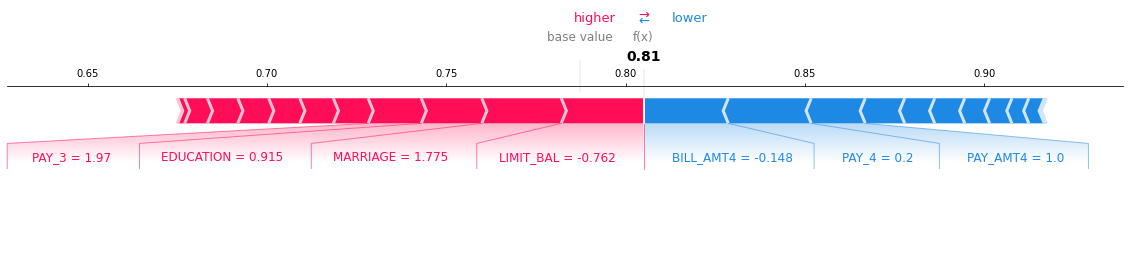

In [58]:
rfc_explainer = shap.TreeExplainer(pipe.named_steps["randomforestclassifier"])
test_rfc_shap_vals = rfc_explainer.shap_values(x_test_t[:100])
shap.force_plot(
    rfc_explainer.expected_value[0],
    test_rfc_shap_vals[0][ex_zero_ind, :],
    x_test_t.loc[ex_zero_ind, :],
    matplotlib=True,
) # for an example where the true target value is zero

You can see above the probability of the prediction being zero. Beneath the bold value, you can see how each of the top features contribute to this prediction as well as how they change the prediction to be higher than the average prediction value for other predictions of zero.

In [59]:
pipe.named_steps["randomforestclassifier"].predict_proba(x_test_t)[ex_one_ind] #predict based on the test set

X has feature names, but RandomForestClassifier was fitted without feature names


array([0.22, 0.78])

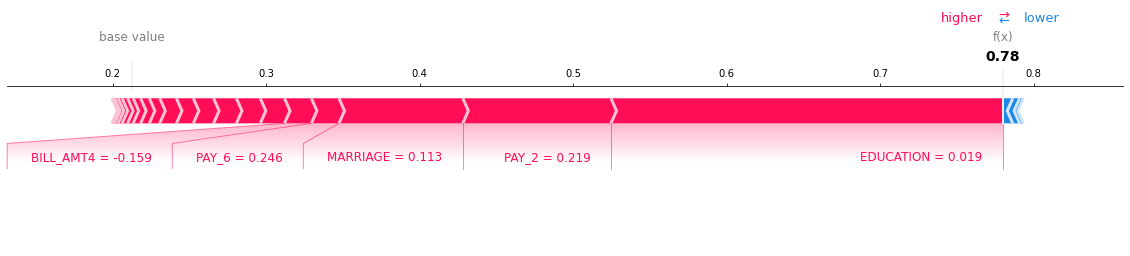

In [60]:
shap.force_plot(
    rfc_explainer.expected_value[1],
    test_rfc_shap_vals[1][ex_one_ind, :],
    x_test_t.loc[ex_one_ind, :],
    matplotlib=True,
) # probability that the prediction is correct (predicting a value of 1)

This prediction is saying that there is a 78% probability that the model correctly predicted the value to be 1. The average prediction percent is quite lower, which implies that there are a lot more predictions for 1 than for zero in the test set that I predicted on.

<br><br>

## Summary of results
<hr>

In [61]:
pd.DataFrame(results_default)

,DC,SVC,RFC,DTC,KNC
fit_time,0.002 (+/- 0.001),0.726 (+/- 0.035),0.865 (+/- 0.051),0.070 (+/- 0.004),0.001 (+/- 0.000)
score_time,0.006 (+/- 0.004),0.304 (+/- 0.012),0.025 (+/- 0.000),0.003 (+/- 0.000),0.165 (+/- 0.013)
test_accuracy,0.787 (+/- 0.000),0.828 (+/- 0.008),0.823 (+/- 0.005),0.727 (+/- 0.019),0.806 (+/- 0.014)
train_accuracy,0.787 (+/- 0.000),0.839 (+/- 0.003),1.000 (+/- 0.000),1.000 (+/- 0.000),0.850 (+/- 0.004)
test_f1,0.000 (+/- 0.000),0.447 (+/- 0.030),0.461 (+/- 0.029),0.379 (+/- 0.038),0.444 (+/- 0.050)
train_f1,0.000 (+/- 0.000),0.488 (+/- 0.009),0.999 (+/- 0.000),0.999 (+/- 0.000),0.569 (+/- 0.015)
test_recall,0.000 (+/- 0.000),0.327 (+/- 0.026),0.358 (+/- 0.038),0.392 (+/- 0.039),0.364 (+/- 0.047)
train_recall,0.000 (+/- 0.000),0.361 (+/- 0.008),0.998 (+/- 0.001),0.998 (+/- 0.001),0.465 (+/- 0.016)
test_precision,0.000 (+/- 0.000),0.711 (+/- 0.049),0.654 (+/- 0.033),0.368 (+/- 0.040),0.570 (+/- 0.050)
train_precision,0.000 (+/- 0.000),0.753 (+/- 0.018),1.000 (+/- 0.000),1.000 (+/- 0.000),0.733 (+/- 0.011)


The table above shows that the RandomForestClassifier performed the best out of the nonlinear models, which led to me choosing to use this classifier. After some hyperparameter tuning, I found that setting the `n_features` parameter to 200 gave us the best test accuracy.

In [62]:
#Show how the final model compares to a dummy classifier on the test set
final_results = {}
final_results['RFC'] = mean_std_cross_val_scores(pipe, X_test, y_test, scoring=scoring_metrics)
final_results['DC'] = mean_std_cross_val_scores(DummyClassifier(), X_test, y_test, scoring=scoring_metrics)
pd.DataFrame(final_results)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


,RFC,DC
fit_time,8.234 (+/- 0.135),0.003 (+/- 0.001)
score_time,0.178 (+/- 0.011),0.006 (+/- 0.001)
test_accuracy,0.813 (+/- 0.004),0.777 (+/- 0.000)
test_f1,0.471 (+/- 0.008),0.000 (+/- 0.000)
test_recall,0.372 (+/- 0.009),0.000 (+/- 0.000)
test_precision,0.640 (+/- 0.022),0.000 (+/- 0.000)


The recall score was not the best as out of all the 'positives' to classify, the model only classified 37% of them correctly. Since this model is not the best at identifying true positives, I would not recommend using it if correctly identifying positive examples with few false negatives is the objective. The precision score is better than the recall score and indicates that the model was fairly accurate at not predicting false positives. However, the overall accuracy of the model indicates that it does indeed work better than the other classifiers that I tested except for the linear SVC model. None of the nonlinear classifiers performed better than the SVC model in terms of accuracy, but models like the DecisionTreeClassifier performed much better in other areas, like fit and score time. The RFC model was much quicker than the linear model in terms of score time but marginally slower in fit time, further reinforcing that the linear model was the best performing model that was tested.

One of the ideas that I wish I could have had the time to explore further would be more complicated feature engineering. I've learned about polynomial fitting and how to engineer features to work with that so that would be where I would start. I would also like to explore more linear classification models as the single one that I chose to work with performed the best out of any classifier. I would start with a LinearRegression model and work from there.